# About timeline_viz.ipynb

This notebook uses the functions defined and demontrasted in *utils_timeline_viz.ipynb* to clean log data and visualize it.
This is a work in progress :)

In [1]:
exec(open('load_utils.py').read())
from utils_timeline_viz import *

importing notebook from utils_timeline_viz.ipynb
importing function: find_student_log_file
importing function: remove_model_events
importing function: calculate_duration
importing function: add_family
importing function: prep_parsing_data
importing function: get_blocks_withTime
importing function: plot_barGraph_new
importing function: action_usage
importing function: plot


In [2]:
def action_usage(df,column,regex):
    '''Given a regex, we detect its use using a particular column
    and then extract a list of time coordinates for when
    they were used. These coordinates are in the format (start_time, duration)
    
    Args:
        df (Pandas dataframe): The dataframe to search in.
        column (str): The column where the action regex might be logged (usualy the Family column)
        regex (str): The regex or often the name of the action family to search for in the column.    

    Returns:
        A list of tuples with start times of the regex and it's duration [(start1,duration1),(start2,duration2),...]
    '''
    if df[column].isnull().values.all():
        return [(0,0)]
    else:
        timecoords = zip(df[df[column].str.contains(regex,na=False)]['Time'],df[df[column].str.contains(regex,na=False)]['Duration'])
        return clean_coords(timecoords)

In [40]:
def axis_absorbance_usage(df):
    x_axis_usage = action_usage(df,'X axis','absorbance')
    y_axis_usage = action_usage(df,'Y axis','absorbance')
    return merge_usage(x_axis_usage,y_axis_usage)

def axis_trialNumber_usage(df):
    x_axis_usage = action_usage(df,'X axis','trialNumber')
    y_axis_usage = action_usage(df,'Y axis','trialNumber')
    return merge_usage(x_axis_usage,y_axis_usage)

def axis_width_usage(df):
    x_axis_usage = action_usage(df,'X axis','cuvetteWidth')
    y_axis_usage = action_usage(df,'Y axis','cuvetteWidth')
    return merge_usage(x_axis_usage,y_axis_usage)

def axis_concentration_usage(df):
    x_axis_usage = action_usage(df,'X axis','concentration')
    y_axis_usage = action_usage(df,'Y axis','concentration')
    return merge_usage(x_axis_usage,y_axis_usage)

def get_value_and_coords(df,variable):
    usage = action_usage(df,'Family',family_name_to_code[variable])
    values = df[df['Family'].str.contains(family_name_to_code[variable],na=False)][variable]
    coords = df[df['Family'].str.contains(family_name_to_code[variable],na=False)]['Time']
    return values, coords, usage

def get_absorbance(df,_):
#     usage = action_usage(df,'Family',".*")
    values = df['Absorbance']
    coords = df['Time']
    return values, coords, None

In [41]:
family_name_to_code = {'Interface':'I',
                        'Restore':'R',
                        'Pause':'P',
                        'Graph (add/del/edit)':'G',
                        'Data Table (del/move)':'Dt',
                        'Notes':'N',
                        'Record':'M',
                        'Detector':'Vd',
                        'Wavelength':'Vw',
                        'Width':'Vc',
                        'Concentration':'Vs',
                        'Laser toggle':'Vl',
                        }

function_to_use = {'Axis - absorbance':axis_absorbance_usage,
                   'Axis - trialNumber':axis_trialNumber_usage,
                   'Axis - width':axis_width_usage,
                   'Axis - concentration':axis_concentration_usage,
                  'Wavelength':get_value_and_coords,
                  'Width':get_value_and_coords,
                  'Concentration':get_value_and_coords,
                   'Absorbance':get_absorbance,
                  'Laser toggle':get_value_and_coords}

to_plot = ['Interface','Notes','Pause','Axis - absorbance','Axis - trialNumber','Axis - width','Axis - concentration','Restore','Graph (add/del/edit)','Data Table (del/move)','Record','Detector','Wavelength','Width','Concentration','Laser toggle','Absorbance']

In [63]:
MIN_MAX = {'Wavelength':(380,780),
           'Width':(0.5,2.0),
           'Concentration':(0.0,200.0),
           'Absorbance':(0.0,3.84),
          'Laser toggle':(0.0,1.0)}

def plot(df,to_plot,family_name_to_code,function_to_use):
    ax = plt.subplot()
    spacing = 10
    margin = 1.0
    max_time = 0
#     colors = sns.color_palette("hls", len(to_plot))
    colors = sns.husl_palette(len(to_plot), l=.4, s=1)
#     sns.palplot(sns.husl_palette(len(to_plot), l=.5, s=.7))
    
    for i,action in enumerate(to_plot):
        alpha = 0.9
        color = colors[i]
        if action in ['Absorbance','Wavelength','Width','Concentration','Laser toggle']:
            #get time coords for changes in that variable, and the values of those changes
            values,coords,action_use = function_to_use[action](df,action)
            min_v,max_v = MIN_MAX[action]
            values = [(v-min_v)/(max_v-min_v)*(spacing-margin) +i*spacing for v in values] #normalize so it fits in x_axis
            if action == 'Absorbance':
                color = 'black'
#             ax.plot(coords,values,'o',color=color,markersize=3,alpha=1)
            ax.plot(coords,values,'-',color=color,linewidth=2,alpha=1)
            alpha = 0.3
        elif action in family_name_to_code.keys():
            action_use = action_usage(df,'Family',family_name_to_code[action])
            action_use = clean_coords(action_use)
        else:
            action_use = function_to_use[action](df)            
        if action_use:
            if action in ['Pause','Notes','Record']:
                a = 0.1
                if action == 'Record':
                    a = 0.5
                ax.broken_barh(action_use,(i*spacing,(spacing)*(len(to_plot)-i)),facecolors=color,linewidth=0,edgecolor='k',alpha=a)
            if 'Axis' in action:
                ax.broken_barh(action_use,(i*spacing,(spacing-margin)),facecolors="grey",alpha=0.3,linewidth=0,edgecolor='k')
                alpha = 0.2
            max_time = max(max_time,sum(action_use[-1]))
            ax.broken_barh(action_use,(i*spacing,(spacing-margin)),facecolors=color,alpha=alpha,linewidth=0,edgecolor='k')

    #Shape plot
    ax.set_ylim(-2, len(to_plot)*spacing+2)
    ax.set_xlim(0, max_time+2)
    
    #Add labels
    ax.set_xlabel('Time (min)',fontsize=25)
    ax.set_xticks(range(0,int(max_time),60))
    ax.set_xticklabels([str(x/60)+''if x in range(0,int(max_time),60*5) else "" for x in range(0,int(max_time),60)],fontsize=13)
    ax2 = ax.twiny()
    ax2.set_xlim(0, max_time+2)
    ax2.set_xlabel('',fontsize=20)
    ax2.set_xticks(range(0,int(max_time),60))
    ax2.set_xticklabels([str(x/60)+''if x in range(0,int(max_time),60*5) else "" for x in range(0,int(max_time),60)],fontsize=13)
    ax.xaxis.set_tick_params(labelsize=20)
    ax.set_yticks(range(spacing/2,len(to_plot)*spacing,spacing))
    ax.set_yticklabels([a.capitalize() for a in to_plot],fontsize=25)
    ax.grid(True)
    ax2.grid(False)

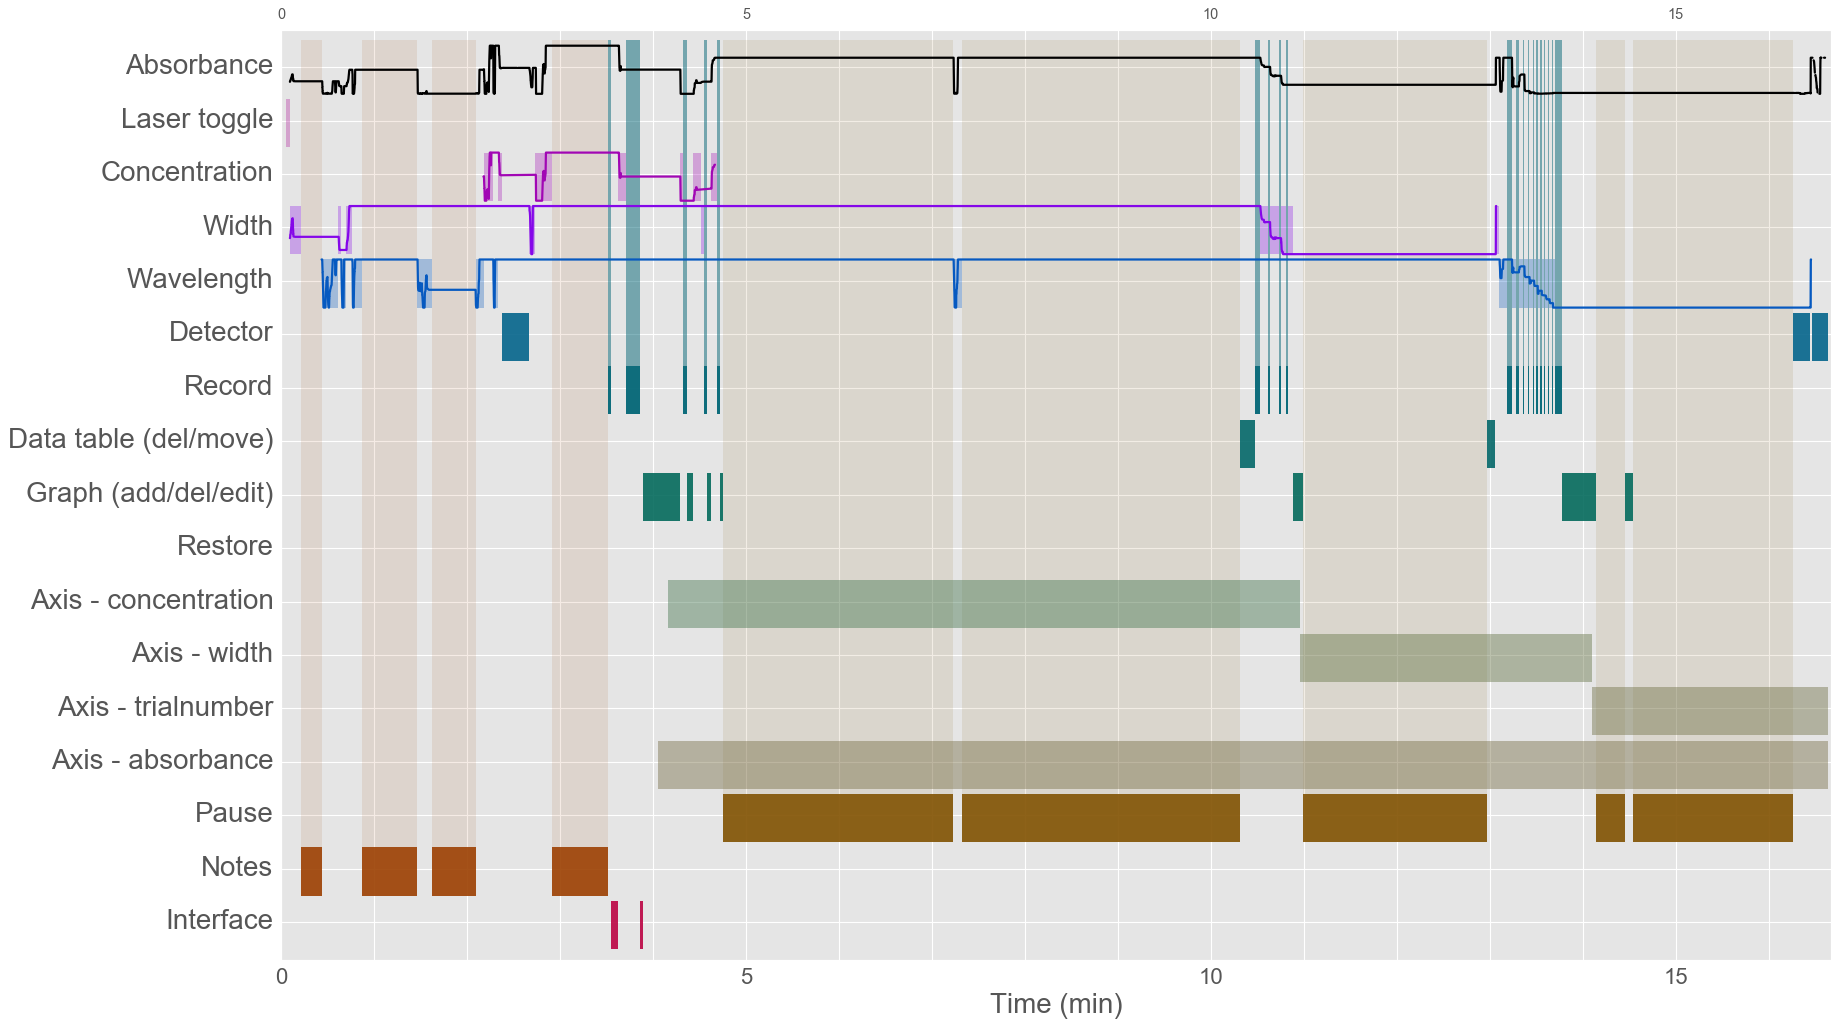

In [64]:
studentid = '90447168';sim = 'beers'
#high pre to high post
#cdw = 333->321
parsed_file = 'dream_table_beers-law-lab_90447168_2017-01-17_11.22.45.txt'
df = prep_parsing_data(parsed_file)
plot(df,to_plot,family_name_to_code,function_to_use)

Wavelength [780.0, 780.0, 780.0, 765.0, 760.0, 741.0, 741.0, 731.0, 726.0, 722.0, 722.0, 707.0, 707.0, 693.0, 683.0, 673.0, 673.0, 649.0, 640.0, 630.0, 615.0, 611.0, 601.0, 596.0, 586.0, 586.0, 577.0, 567.0, 567.0, 557.0, 557.0, 548.0, 538.0, 524.0, 519.0, 514.0, 509.0, 504.0, 500.0, 495.0, 490.0, 485.0, 480.0, 480.0, 471.0, 466.0, 466.0, 456.0, 456.0, 446.0, 442.0, 427.0, 427.0, 417.0, 417.0, 408.0, 398.0, 398.0, 388.0, 380.0, 380.0, 380.0, 380.0, 380.0, 380.0, 380.0, 380.0, 380.0, 380.0, 380.0, 380.0, 380.0, 380.0, 380.0, 380.0, 380.0, 380.0, 380.0, 380.0, 380.0, 380.0, 380.0, 380.0, 380.0, 380.0, 380.0, 380.0, 380.0, 380.0, 380.0, 380.0, 380.0, 380.0, 380.0, 380.0, 380.0, 380.0, 380.0, 380.0, 380.0, 380.0, 380.0, 380.0, 380.0, 380.0, 380.0, 380.0, 380.0, 380.0, 380.0, 380.0, 380.0, 380.0, 380.0, 380.0, 380.0, 380.0, 380.0, 380.0, 380.0, 380.0, 380.0, 380.0, 380.0, 380.0, 380.0, 380.0, 380.0, 380.0, 380.0, 380.0, 380.0, 380.0, 380.0, 388.0, 393.0, 398.0, 403.0, 422.0, 422.0, 442.0, 4

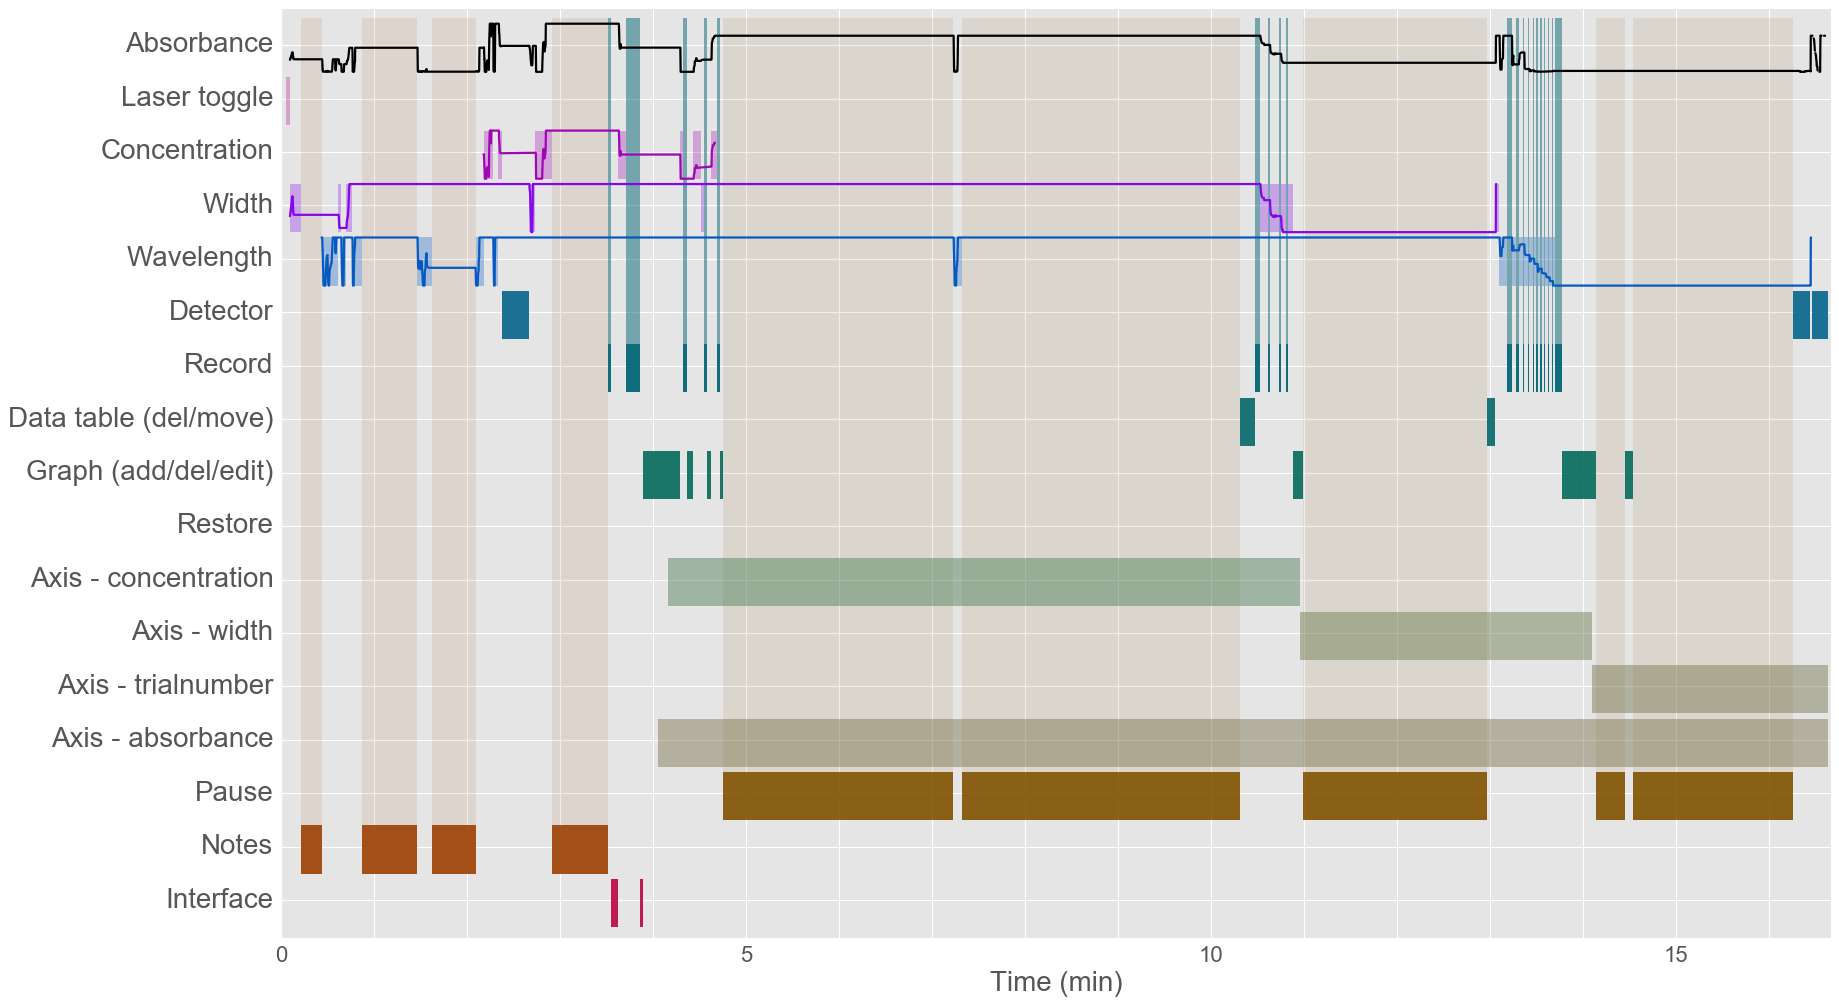

In [46]:
studentid = '90447168';sim = 'beers'
#high pre to high post
#cdw = 333->321
parsed_file = 'dream_table_beers-law-lab_90447168_2017-01-17_11.22.45.txt'
df = prep_parsing_data(parsed_file)
plot(df,to_plot,family_name_to_code,function_to_use)

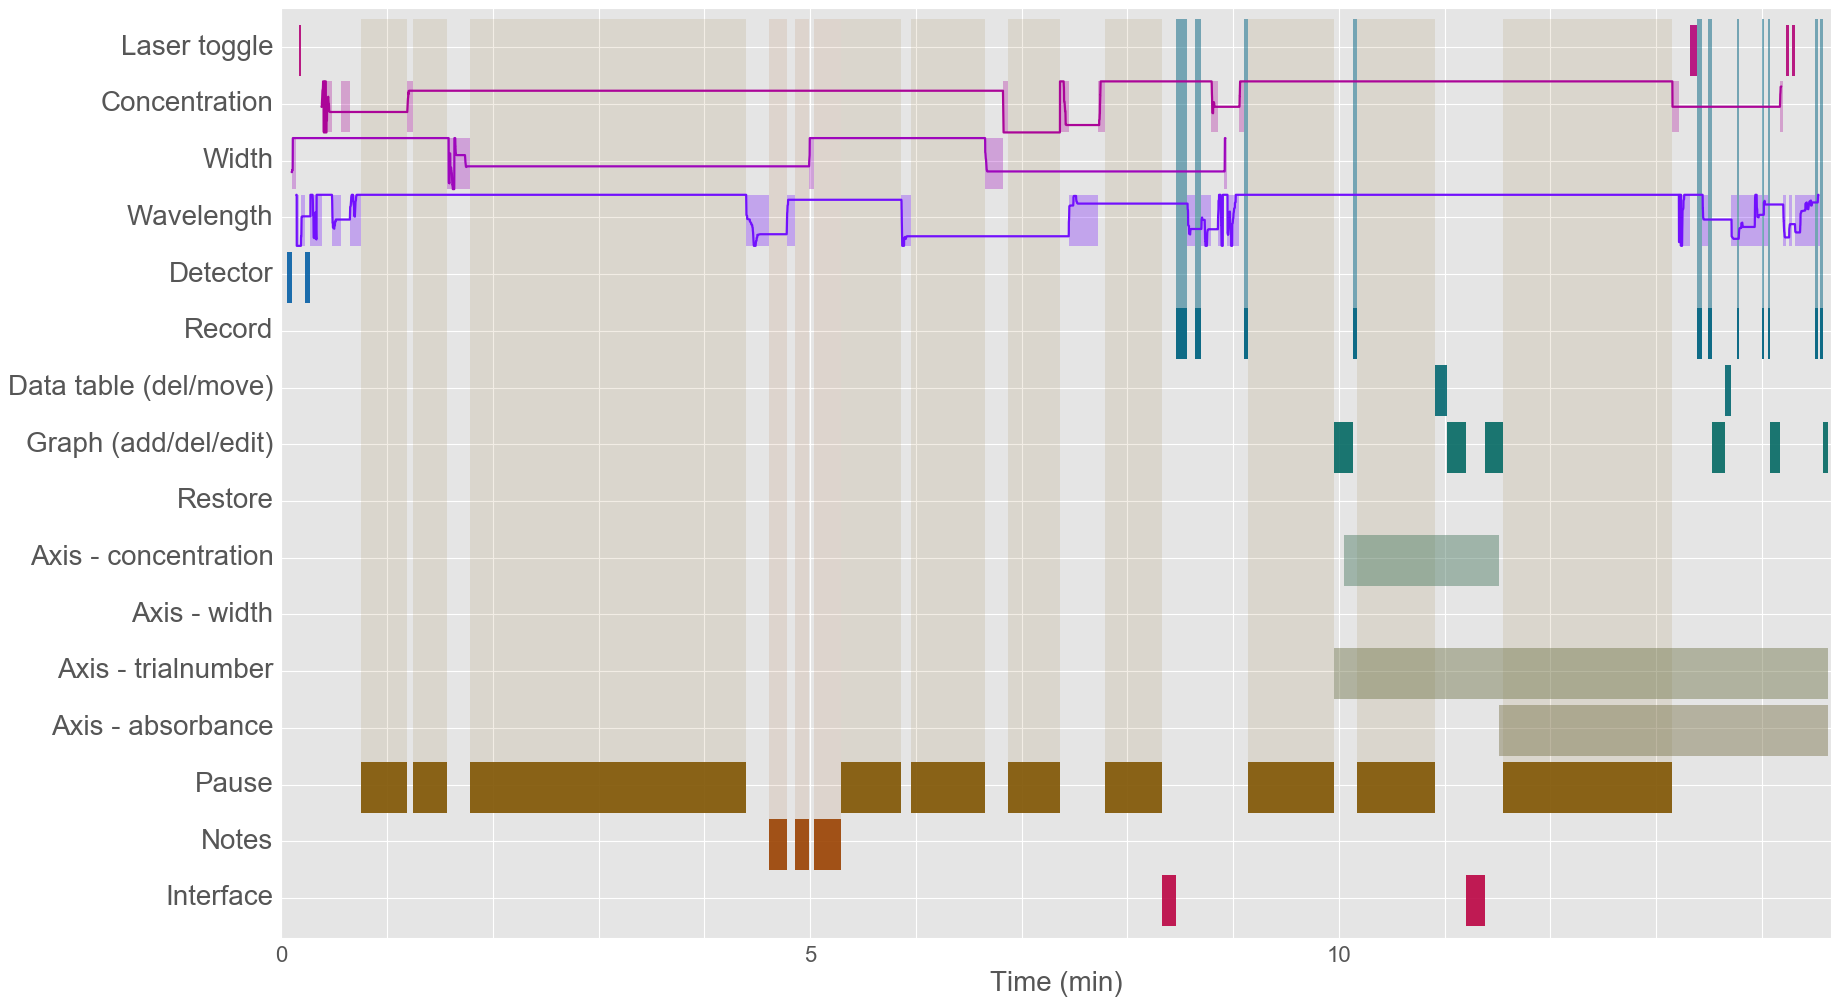

In [8]:
studentid = '19566168';sim = 'beers'
#cdw = 101->222
parsed_file = 'dream_table_beers-law-lab_19566168_2017-01-27_13.27.13.txt'
df2 = prep_parsing_data(parsed_file)
plot(df2,to_plot,family_name_to_code,function_to_use)

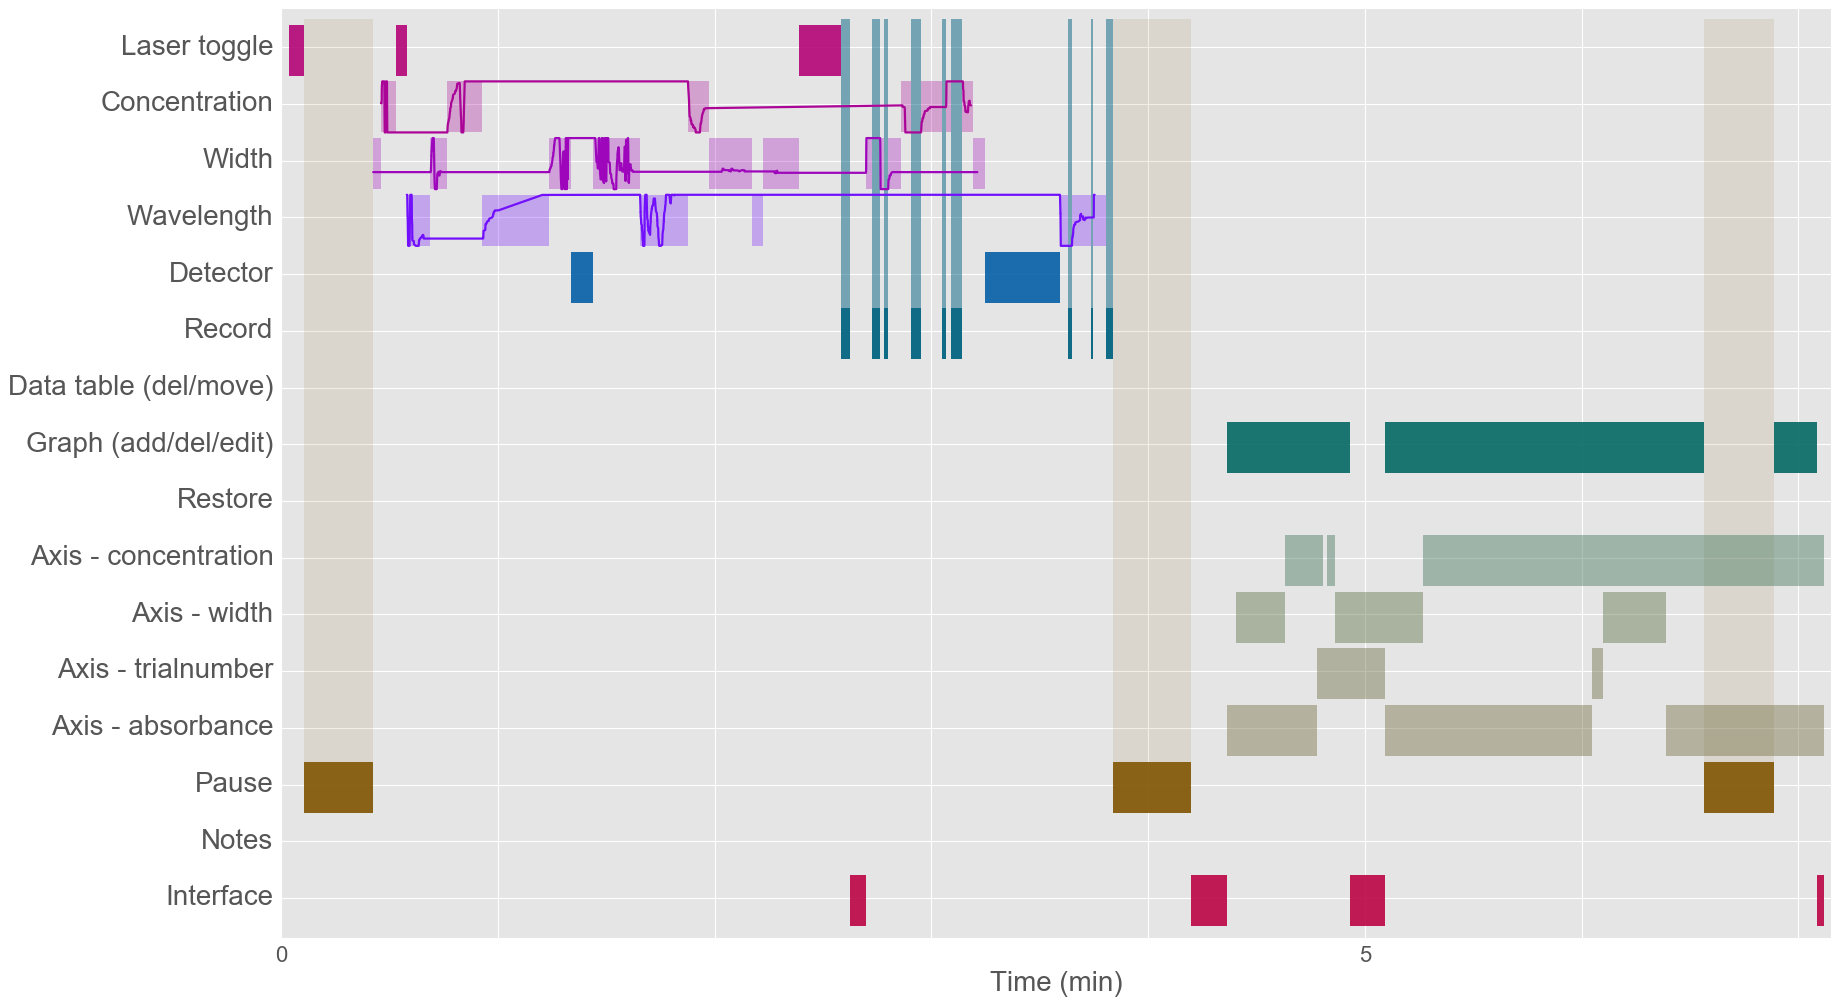

In [9]:
studentid = '12263156';sim = 'beers'
#main, cdw = 111
parsed_file = 'dream_table_beers-law-lab_12263156_2017-01-20_15.25.01.txt'
df3 = prep_parsing_data(parsed_file)
plot(df3,to_plot,family_name_to_code,function_to_use)

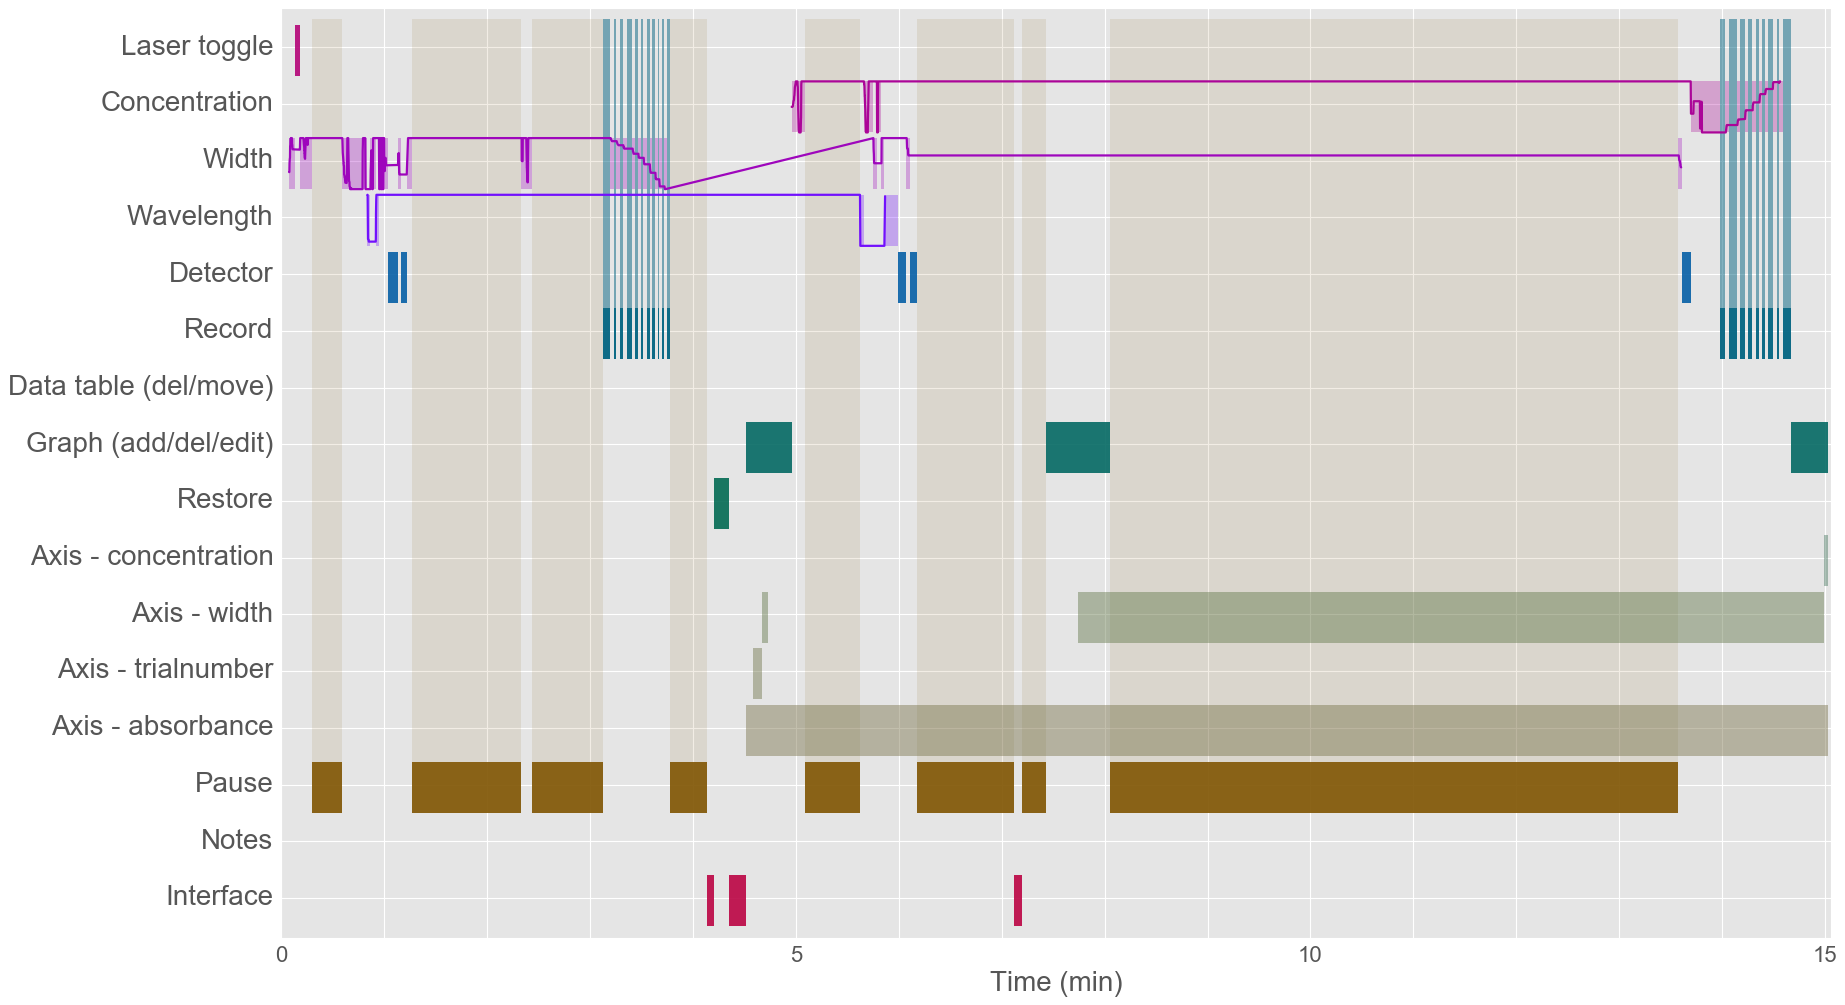

In [10]:
studentid = '16317166'
#main, cdw = 231
parsed_file = find_student_log_file(sim,studentid,date='2017-03-21_17.28.42')
df4 = prep_parsing_data(parsed_file)
plot(df4,to_plot,family_name_to_code,function_to_use)